## Primer prompt de prueba
El siguiente código de Python da lo que se verá a continuación:

Dataset shape: (400, 64, 64)
Number of patches: 20000


C:\Users\Aurel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=6.840e-03, previous alpha=6.840e-03, with an active set of 12 regressors.
  warnings.warn(


Dictionary shape: (100, 256)
Sparse code shape: (20000, 100)


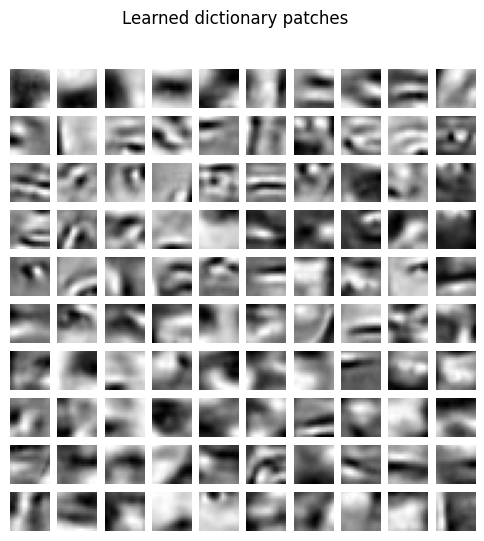

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------
# 1) LOAD IMAGE DATASET FROM SKLEARN
# ------------------------------------------------------

# Olivetti faces: 400 grayscale images of size 64x64
dataset = fetch_olivetti_faces()

images = dataset.images   # shape: (400, 64, 64)

print("Dataset shape:", images.shape)

# ------------------------------------------------------
# 2) EXTRACT PATCHES (16x16)
# ------------------------------------------------------

patch_size = (16, 16)

# Extract many random patches from all images
patches = []

for img in images:
    p = extract_patches_2d(img, patch_size, max_patches=50, random_state=0)
    patches.append(p)

patches = np.concatenate(patches, axis=0)

print("Number of patches:", patches.shape[0])

# Flatten each patch into a vector
patches = patches.reshape(patches.shape[0], -1)

# ------------------------------------------------------
# Normalize patches (important for dictionary learning)
# ------------------------------------------------------

scaler = StandardScaler(with_mean=True, with_std=True)
patches = scaler.fit_transform(patches)

# ------------------------------------------------------
# 3) LEARN SPARSE DICTIONARY
# ------------------------------------------------------

n_components = 100   # number of dictionary atoms (basis patches)

dict_learner = MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=1,              # sparsity regularization (higher = sparser)
    batch_size=256,
    random_state=0
)

# Learn dictionary
dictionary = dict_learner.fit(patches).components_

print("Dictionary shape:", dictionary.shape)
# (n_components, 256) since 16x16 = 256 pixels

# ------------------------------------------------------
# 4) COMPUTE SPARSE REPRESENTATIONS (CODES)
# ------------------------------------------------------

sparse_codes = dict_learner.transform(patches)

print("Sparse code shape:", sparse_codes.shape)

# Each patch ≈ sparse linear combination of dictionary atoms

# ------------------------------------------------------
# 5) VISUALIZE SOME LEARNED DICTIONARY ATOMS
# ------------------------------------------------------

fig, axes = plt.subplots(10, 10, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    atom = dictionary[i].reshape(16, 16)
    ax.imshow(atom, cmap="gray")
    ax.axis("off")

plt.suptitle("Learned dictionary patches")
plt.show()


Explicación paso a paso del proceso de Dictionary Learning con scikit-learn

En primer lugar se carga un conjunto de datos de imágenes disponible directamente en la API de scikit-learn. En este caso se utiliza el dataset fetch_olivetti_faces, que contiene 400 imágenes en escala de grises de tamaño 64×64 píxeles. Estas imágenes representan distintos rostros y son un conjunto clásico en tareas de procesamiento de imagen y aprendizaje no supervisado. No se realiza ningún redimensionado de las imágenes, respetando su tamaño original.

A continuación se extraen parches pequeños de cada imagen utilizando la función extract_patches_2d. Un parche es una subimagen local, en este caso de tamaño 16×16 píxeles. De cada imagen se extraen múltiples parches aleatorios, lo que permite obtener miles de ejemplos locales que capturan estructuras simples como bordes, texturas y patrones básicos. Estos parches constituyen los datos de entrada reales para el aprendizaje del diccionario.

Una vez extraídos, cada parche se transforma en un vector unidimensional de longitud 256 (porque 16×16 = 256). Esto es necesario porque los algoritmos de scikit-learn trabajan con matrices de datos donde cada fila representa una muestra y cada columna una característica.

Antes de aprender el diccionario, los parches se normalizan utilizando StandardScaler. Esta normalización centra los datos en media cero y varianza unitaria, lo cual es importante para que el algoritmo no favorezca píxeles con mayor escala de valores y para mejorar la estabilidad numérica del proceso de optimización.

Posteriormente se aplica el algoritmo de Dictionary Learning mediante la clase MiniBatchDictionaryLearning. Este método busca aprender un conjunto de vectores base, llamados átomos del diccionario, de tal forma que cada parche pueda representarse como una combinación lineal de unos pocos de estos átomos. Se especifica el número de componentes del diccionario, por ejemplo 100, que corresponde al número de patrones básicos que se desean aprender. El parámetro alpha controla el nivel de esparsidad, forzando a que cada parche se represente usando solo unos pocos átomos.

El algoritmo se entrena ajustando el diccionario a todos los parches extraídos. Como resultado se obtiene una matriz donde cada fila corresponde a un átomo del diccionario, es decir, un patrón visual típico de tamaño 16×16 píxeles.

Después de aprender el diccionario, se calcula la representación dispersa de cada parche mediante el método transform. Esto produce una matriz de coeficientes donde cada fila contiene los pesos con los que se combinan los átomos del diccionario para reconstruir un parche concreto. La mayoría de estos coeficientes son cercanos a cero, lo que confirma la propiedad de esparsidad.

Finalmente, los átomos aprendidos se visualizan reordenando cada vector de 256 elementos en una imagen de 16×16 píxeles. Estas imágenes suelen mostrar estructuras similares a bordes orientados, manchas de intensidad o pequeñas texturas, que son los bloques básicos con los que se pueden reconstruir los parches originales.

En conjunto, este procedimiento permite aprender automáticamente una base eficiente de patrones visuales a partir de datos sin etiquetar, logrando una representación compacta y esparsa de las imágenes, lo cual es útil en compresión, eliminación de ruido y análisis de características.